{"metadata": {
  "kernelspec": {
    "display_name": "Python 3",
    "language": "python",
    "name": "python3"
  },
  "language_info": {
    "codemirror_mode": {
      "name": "ipython",
      "version": 3
    },
    "file_extension": ".py",
    "mimetype": "text/x-python",
    "name": "python",
    "nbconvert_exporter": "python",
    "pygments_lexer": "ipython3",
    "version": "3.8.0"
  },
  "widgets": {
    "application/vnd.jupyter.widget-state+json": {
      "state": {},
      "version_major": 2,
      "version_minor": 0
    }
  }
},
"nbformat": 4,
"nbformat_minor": 5}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import time

In [ ]:
# --- 1. Data
df_train = pd.read_csv('/content/drive/MyDrive/MS Research/Sem 1/ML/ait-511-course-project-1-obesity-risk/train.csv')
df_test_raw = pd.read_csv('/content/drive/MyDrive/MS Research/Sem 1/ML/ait-511-course-project-1-obesity-risk/test.csv')
print("Data loaded successfully.")

Data loaded successfully.


In [ ]:
df_train.drop('id', axis=1, inplace=True)
test_ids = df_test_raw['id'] # Saving test IDs for final submission mapping
df_test_raw.drop('id', axis=1, inplace=True)

In [ ]:
df_train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:

!pip install ydata-profiling

In [ ]:
import pandas as pd
from ydata_profiling import ProfileReport

profile = ProfileReport(df_train, title="My Data Profile")
profile
profile.to_file("my_data_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 17/17 [00:01<00:00,  8.71it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# ----------------------------------------------------------------------
# GLOBAL VARIABLE
# ----------------------------------------------------------------------
TARGET_COL = 'WeightCategory'
RANDOM_STATE = 42
K_FOLDS = 5

# All continuous features based on domain knowledge and data preview
NUM_COLS = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# All object (categorical) features
CAT_COLS = df_train.select_dtypes(include=['object']).drop(TARGET_COL, axis=1).columns.tolist()

# Binary Categorical Features (where OHE would result in only 2 columns)
BIN_COLS = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

# Nominal Categorical Features (more than 2 unique values)
NOM_COLS = [col for col in CAT_COLS if col not in BIN_COLS]

print(f"\nTraining Data Shape: {df_train.shape}")
print(f"Target distribution:\n{df_train[TARGET_COL].value_counts()}")




Training Data Shape: (15533, 17)
Target distribution:
WeightCategory
Obesity_Type_III       2983
Obesity_Type_II        2403
Normal_Weight          2345
Obesity_Type_I         2207
Overweight_Level_II    1881
Insufficient_Weight    1870
Overweight_Level_I     1844
Name: count, dtype: int64


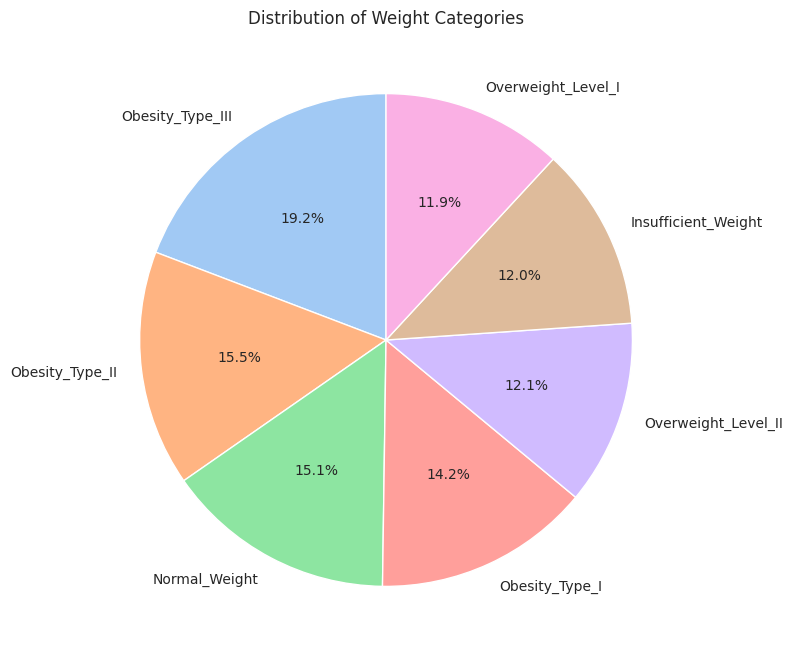

In [ ]:
plt.figure(figsize=(8, 8))
df_train[TARGET_COL].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Weight Categories')
plt.ylabel('') # Remove default y-label
plt.show()

In [ ]:
# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- 2. EDA: Descriptive Statistics & Visualizations ---")

print("\n2.1. Descriptive Statistics for Numerical Features:")
print(df_train[NUM_COLS].describe().T)

print("\n2.2. Missing Values Check:")
print(df_train.isnull().sum())


--- 2. EDA: Descriptive Statistics & Visualizations ---

2.1. Descriptive Statistics for Numerical Features:
          count       mean        std    min        25%        50%  \
Age     15533.0  23.816308   5.663167  14.00  20.000000  22.771612   
Height  15533.0   1.699918   0.087670   1.45   1.630927   1.700000   
Weight  15533.0  87.785225  26.369144  39.00  66.000000  84.000000   
FCVC    15533.0   2.442917   0.530895   1.00   2.000000   2.342220   
NCP     15533.0   2.760425   0.706463   1.00   3.000000   3.000000   
CH2O    15533.0   2.027626   0.607733   1.00   1.796257   2.000000   
FAF     15533.0   0.976968   0.836841   0.00   0.007050   1.000000   
TUE     15533.0   0.613813   0.602223   0.00   0.000000   0.566353   

               75%         max  
Age      26.000000   61.000000  
Height    1.762921    1.975663  
Weight  111.600553  165.057269  
FCVC      3.000000    3.000000  
NCP       3.000000    4.000000  
CH2O      2.531456    3.000000  
FAF       1.582675    3.0000

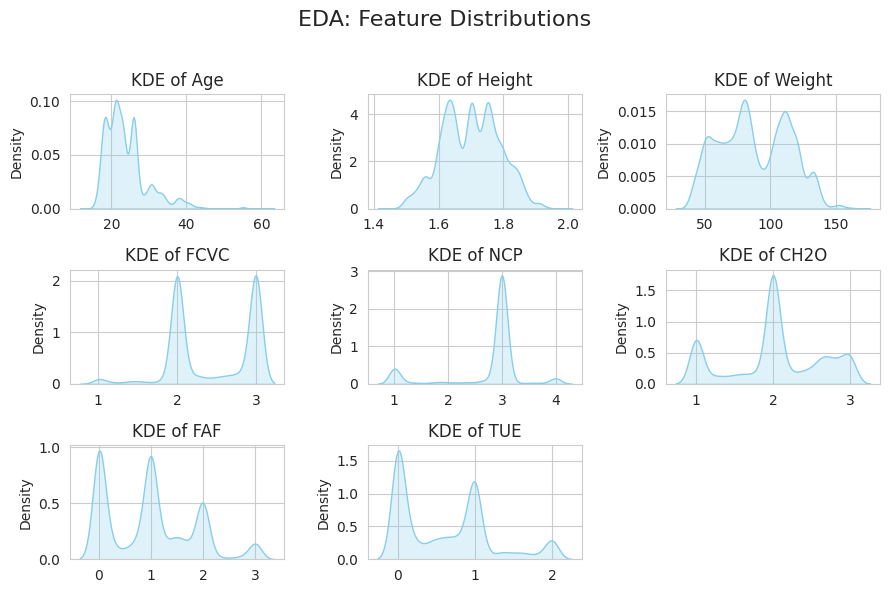

In [ ]:
# Set up the visualization style
sns.set_style("whitegrid")
plt.figure(figsize=(9, 6))
plt.suptitle('EDA: Feature Distributions', fontsize=16)

# Plotting KDE for Numerical Features
for i, col in enumerate(NUM_COLS):
    plt.subplot(3, 3, i + 1)
    sns.kdeplot(df_train[col], fill=True, color='skyblue')
    plt.title(f'KDE of {col}', fontsize=12)
    plt.xlabel('')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

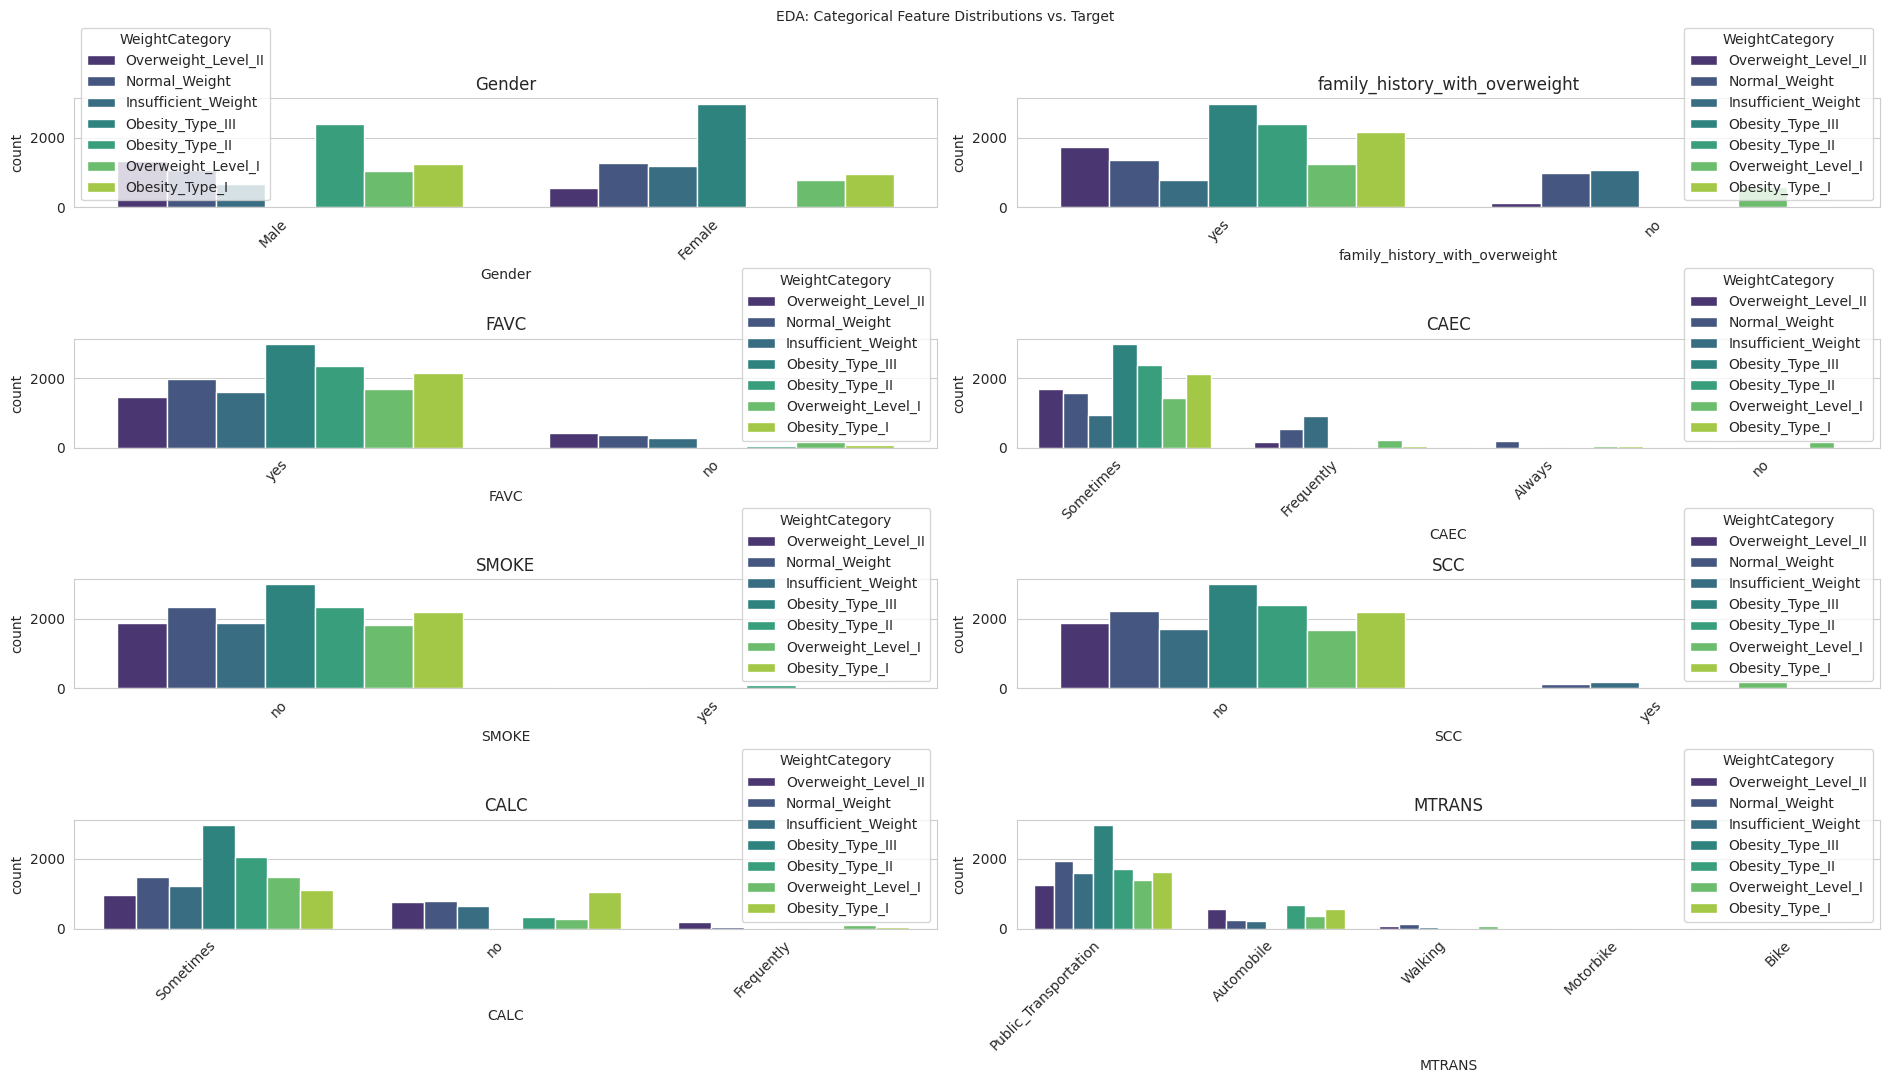

In [ ]:
# Plotting Class Distribution for Categorical Features
plt.figure(figsize=(19, 11))
plt.suptitle('EDA: Categorical Feature Distributions vs. Target', fontsize=10)

for i, col in enumerate(CAT_COLS):
    plt.subplot(4, 2, i + 1)
    # Use value counts to handle potential spacing/case issues
    sns.countplot(x=df_train[col], hue=df_train[TARGET_COL], palette='viridis',
                  order=df_train[col].value_counts().index)
    plt.title(col, fontsize=12)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



2.3. Correlation Analysis:

2.3.1. Pearson Correlation Matrix for Numerical Features:


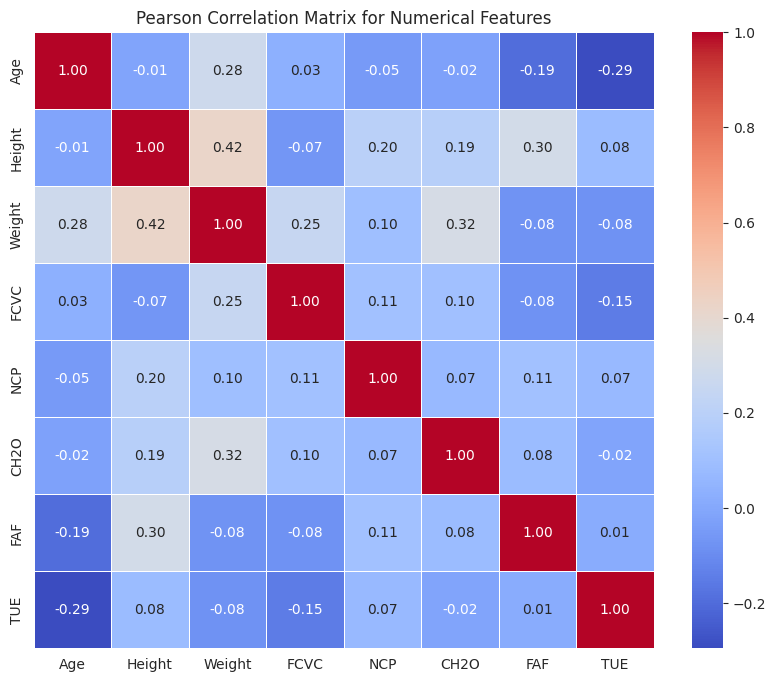

In [ ]:
# --- 2.3. Correlation Analysis ---
print("\n2.3. Correlation Analysis:")

# Correlation for Numerical Features (Pearson)
print("\n2.3.1. Pearson Correlation Matrix for Numerical Features:")
# Use the extended numerical columns list if feature engineering has been done, otherwise use original
current_num_cols = NUM_COLS_EXTENDED if 'NUM_COLS_EXTENDED' in globals() else NUM_COLS
numerical_corr_pearson = df_train[current_num_cols].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_corr_pearson, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Matrix for Numerical Features')
plt.show()


In [ ]:
# --- 3. Data Preprocessing Pipeline ---

# Label Encode the target variable (Y)
le = LabelEncoder()
y = le.fit_transform(df_train[TARGET_COL])
X = df_train.drop(TARGET_COL, axis=1)

# Split data into training and validation sets for initial tuning and comparison
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [ ]:

# 3.1. Define Preprocessing Steps

numeric_transformer = Pipeline(steps=[
    # Scaling is MANDATORY for KNN and Linear models
    ('scaler', StandardScaler())
])

# Use One-Hot Encoding for all categoricals for maximum flexibility and to avoid
# incorrect ordinal assumptions, especially for the Naive Bayes model.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create the full preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUM_COLS),
        ('cat', categorical_transformer, CAT_COLS)
    ],
    remainder='passthrough'
)

# Fit the preprocessor on the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print("\n3.2. Preprocessing Complete:")
print(f"Original features: {X_train.shape[1]}")
print(f"Processed features: {X_train_processed.shape[1]}")


3.2. Preprocessing Complete:
Original features: 16
Processed features: 30


In [ ]:
# --- 4. Model Application, K-Fold CV, and Hyperparameter Tuning ---

# Define K-Fold strategy
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
# --- A. Decision Tree (CART) ---
print("\n--- 4.A. Decision Tree (CART) Tuning ---")
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))])

# Hyperparameter Grid for DT
dt_param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)

best_dt = dt_grid_search.best_estimator_
dt_cv_score = dt_grid_search.best_score_
dt_val_accuracy = best_dt.score(X_val, y_val)

print(f"Best DT Params: {dt_grid_search.best_params_}")
print(f"Best DT CV Accuracy: {dt_cv_score:.4f}")
print(f"DT Validation Accuracy: {dt_val_accuracy:.4f}")


--- 4.A. Decision Tree (CART) Tuning ---
Best DT Params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10}
Best DT CV Accuracy: 0.8704
DT Validation Accuracy: 0.8716


In [ ]:
# --- B. K-Nearest Neighbors (KNN) ---
print("\n--- 4.B. K-Nearest Neighbors (KNN) Tuning ---")
# NOTE: The StandardScaler is inside the 'preprocessor' and is essential here.
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', KNeighborsClassifier())])

# Hyperparameter Grid for KNN
knn_param_grid = {
    'classifier__n_neighbors': list(range(3, 20, 2)), # Odd K values
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2] # 1=Manhattan, 2=Euclidean
}

knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
knn_grid_search.fit(X_train, y_train)

best_knn = knn_grid_search.best_estimator_
knn_cv_score = knn_grid_search.best_score_
knn_val_accuracy = best_knn.score(X_val, y_val)

print(f"Best KNN Params: {knn_grid_search.best_params_}")
print(f"Best KNN CV Accuracy: {knn_cv_score:.4f}")
print(f"KNN Validation Accuracy: {knn_val_accuracy:.4f}")


--- 4.B. K-Nearest Neighbors (KNN) Tuning ---
Best KNN Params: {'classifier__n_neighbors': 11, 'classifier__p': 1, 'classifier__weights': 'distance'}
Best KNN CV Accuracy: 0.7875
KNN Validation Accuracy: 0.7821


In [ ]:
# --- C. Naive Bayes (GaussianNB) ---
print("\n--- 4.C. Naive Bayes (GaussianNB) Baseline ---")
# Use GaussianNB, which assumes continuous features follow a Gaussian distribution.
# This model does not require tuning the same way DT or KNN does.

nb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', GaussianNB())])

nb_pipeline.fit(X_train, y_train)
nb_val_accuracy = nb_pipeline.score(X_val, y_val)

# Perform simple K-Fold CV score calculation
nb_cv_scores = cross_val_score(nb_pipeline, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
nb_cv_score = nb_cv_scores.mean()


print(f"NB Mean CV Accuracy: {nb_cv_score:.4f}")
print(f"NB Validation Accuracy: {nb_val_accuracy:.4f}")


--- 4.C. Naive Bayes (GaussianNB) Baseline ---
NB Mean CV Accuracy: 0.5818
NB Validation Accuracy: 0.5832


In [ ]:
# --- D. AdaBoost Classifier ---
print("\n--- 4.D. AdaBoost Classifier Tuning ---")
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost
adaboost_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', AdaBoostClassifier(random_state=RANDOM_STATE))])

# Hyperparameter Grid for AdaBoost
adaboost_param_grid = {
    'classifier__n_estimators': [50, 100, 200], # Number of boosting rounds
    'classifier__learning_rate': [0.01, 0.1, 0.5, 1.0], # Contribution of each weak learner
    'classifier__estimator__max_depth': [1, 2, 3] # Max depth of the base Decision Tree (weak learner)
}

adaboost_pipeline.set_params(classifier__estimator=DecisionTreeClassifier(random_state=RANDOM_STATE))


adaboost_grid_search = GridSearchCV(adaboost_pipeline, adaboost_param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
adaboost_grid_search.fit(X_train, y_train)

best_adaboost = adaboost_grid_search.best_estimator_
adaboost_cv_score = adaboost_grid_search.best_score_
adaboost_val_accuracy = best_adaboost.score(X_val, y_val)

print(f"Best AdaBoost Params: {adaboost_grid_search.best_params_}")
print(f"Best AdaBoost CV Accuracy: {adaboost_cv_score:.4f}")
print(f"AdaBoost Validation Accuracy: {adaboost_val_accuracy:.4f}")


--- 4.D. AdaBoost Classifier Tuning ---
Best AdaBoost Params: {'classifier__estimator__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
Best AdaBoost CV Accuracy: 0.8687
AdaBoost Validation Accuracy: 0.8684


In [ ]:
# --- 5. Comparative Study and Conclusion ---

results = pd.DataFrame({
    'Model': ['Decision Tree (CART)', 'K-Nearest Neighbors (KNN)', 'Gaussian Naive Bayes'],
    f'Mean CV Accuracy (K={K_FOLDS})': [dt_cv_score, knn_cv_score, nb_cv_score],
    'Validation Accuracy': [dt_val_accuracy, knn_val_accuracy, nb_val_accuracy],
    'Best Hyperparameters': [dt_grid_search.best_params_, knn_grid_search.best_params_, 'N/A']
})

results_sorted = results.sort_values(by='Mean CV Accuracy (K=5)', ascending=False).reset_index(drop=True)

print("\n--- 5. Comparative Model Performance (Checkpoint 1 Models) ---")
print(results_sorted.to_markdown(index=False))

# Identify the best model for detailed report
best_model_name = results_sorted.iloc[0]['Model']
if best_model_name == 'Decision Tree (CART)':
    final_best_model = best_dt
elif best_model_name == 'K-Nearest Neighbors (KNN)':
    final_best_model = best_knn
else:
    final_best_model = nb_pipeline # Naive Bayes

print(f"\nConclusion: The best performing model for Checkpoint 1 is the {best_model_name}.")
print("Final Report")



--- 5. Comparative Model Performance (Checkpoint 1 Models) ---
| Model                     |   Mean CV Accuracy (K=5) |   Validation Accuracy | Best Hyperparameters                                                                                  |
|:--------------------------|-------------------------:|----------------------:|:------------------------------------------------------------------------------------------------------|
| Decision Tree (CART)      |                 0.870432 |              0.87158  | {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10} |
| K-Nearest Neighbors (KNN) |                 0.787542 |              0.782105 | {'classifier__n_neighbors': 11, 'classifier__p': 1, 'classifier__weights': 'distance'}                |
| Gaussian Naive Bayes      |                 0.581843 |              0.583199 | N/A                                                                                                   |

Conclusion


--- Detailed Classification Report for Decision Tree (CART) ---
                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.93      0.91       374
      Normal_Weight       0.84      0.84      0.84       469
     Obesity_Type_I       0.82      0.85      0.84       441
    Obesity_Type_II       0.95      0.94      0.95       481
   Obesity_Type_III       0.99      1.00      0.99       597
 Overweight_Level_I       0.73      0.71      0.72       369
Overweight_Level_II       0.79      0.73      0.76       376

           accuracy                           0.87      3107
          macro avg       0.86      0.86      0.86      3107
       weighted avg       0.87      0.87      0.87      3107



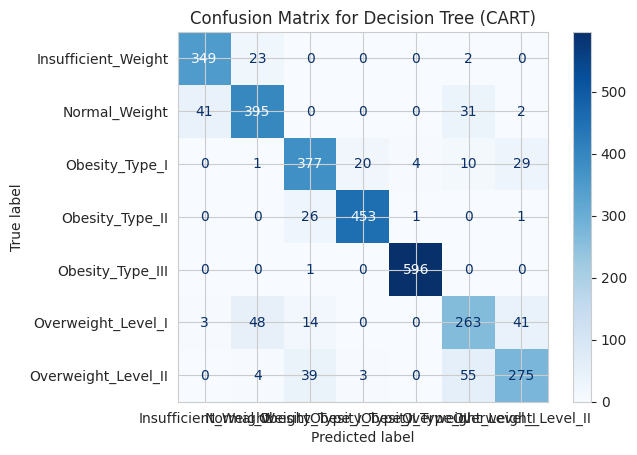

In [ ]:
# Detailed report for the best model
y_pred_final = final_best_model.predict(X_val)

print(f"\n--- Detailed Classification Report for {best_model_name} ---")
print(classification_report(y_val, y_pred_final, target_names=le.classes_))

# Visualize Confusion Matrix for Viva performance
ConfusionMatrixDisplay.from_estimator(final_best_model, X_val, y_val, display_labels=le.classes_, cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

# Results
test_predictions_encoded = final_best_model.predict(df_test_raw)
test_predictions_labels = le.inverse_transform(test_predictions_encoded)

submission_df = pd.DataFrame({
    'id': test_ids,
    'WeightCategory': test_predictions_labels
})

In [ ]:
# Save the submission file
submission_df.to_csv('submission_checkpoint1.csv', index=False)
print("\nFinal submission file generated: 'submission_checkpoint1.csv'")
print("This file contains predictions from the best performing Checkpoint 1 model.")


Final submission file generated: 'submission_checkpoint1.csv'
This file contains predictions from the best performing Checkpoint 1 model.


In [ ]:
# --- 5. Feature Engineering ---
print("\n--- 5. Feature Engineering ---")

# BMI
df_train['BMI'] = df_train['Weight'] / (df_train['Height']**2)
df_test_raw['BMI'] = df_test_raw['Weight'] / (df_test_raw['Height']**2)

#'Age' and 'BMI'
df_train['Age_BMI_Interaction'] = df_train['Age'] * df_train['BMI']
df_test_raw['Age_BMI_Interaction'] = df_test_raw['Age'] * df_test_raw['BMI']

# FAF and CH2O
df_train['FAF_CH2O_Interaction'] = df_train['FAF'] * df_train['CH2O']
df_test_raw['FAF_CH2O_Interaction'] = df_test_raw['FAF'] * df_test_raw['CH2O']

# FAVC AND FCVC
df_train['FAVC_FCVC_Interaction'] = (df_train['FAVC'] == 'yes').astype(int) * df_train['FCVC']
df_test_raw['FAVC_FCVC_Interaction'] = (df_test_raw['FAVC'] == 'yes').astype(int) * df_test_raw['FCVC']


# PCA on binary categorical features (SMOKE, SCC, FAVC)
from sklearn.decomposition import PCA

binary_features_train = df_train[BIN_COLS]
binary_features_test = df_test_raw[BIN_COLS]

# One-Hot Encode binary features for PCA
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
binary_features_train_encoded = ohe.fit_transform(binary_features_train)
binary_features_test_encoded = ohe.transform(binary_features_test)

# Apply PCA - let's aim for 1 principal component as these are only 3 binary features
pca = PCA(n_components=1)
pca_components_train = pca.fit_transform(binary_features_train_encoded)
pca_components_test = pca.transform(binary_features_test_encoded)

# PCA ass new feature
df_train['Binary_PCA'] = pca_components_train
df_test_raw['Binary_PCA'] = pca_components_test

NUM_COLS_EXTENDED = NUM_COLS + ['BMI', 'Age_BMI_Interaction', 'FAF_CH2O_Interaction', 'FAVC_FCVC_Interaction', 'Binary_PCA']

print("Training DataFrame with new features:")
display(df_train.head())
print("\nRaw Test DataFrame with new features:")
display(df_test_raw.head())


--- 5. Feature Engineering ---
Training DataFrame with new features:


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,FAF,TUE,CALC,MTRANS,WeightCategory,BMI,Age_BMI_Interaction,FAF_CH2O_Interaction,FAVC_FCVC_Interaction,Binary_PCA
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565,690.748852,0.000000,2.000000,-0.745191
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091,421.597633,2.000000,2.000000,0.644426
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706,308.280704,1.654473,1.880534,0.644426
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798,939.851747,2.457292,3.000000,0.644426
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151,809.984810,3.896287,2.679664,-0.745191



Raw Test DataFrame with new features:


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,MTRANS,BMI,Age_BMI_Interaction,FAF_CH2O_Interaction,FAVC_FCVC_Interaction,Binary_PCA
0,Female,19.007177,1.772449,137.852618,yes,yes,3.000000,3.000000,Sometimes,no,...,no,1.465931,0.813235,Sometimes,Public_Transportation,43.880091,834.036663,2.942634,3.000000,0.644426
1,Female,21.572114,1.698346,75.000000,yes,yes,2.000000,3.000000,Sometimes,no,...,no,1.577824,1.865851,Sometimes,Public_Transportation,26.002130,560.920903,3.155648,2.000000,0.644426
2,Male,22.285024,1.737453,82.000000,yes,yes,2.000000,2.720642,Sometimes,no,...,no,0.451009,0.000000,Sometimes,Public_Transportation,27.163625,605.342029,0.825623,2.000000,-0.745191
3,Male,30.916426,1.775580,120.860386,yes,yes,2.712747,3.000000,Sometimes,no,...,no,0.712726,0.100048,Sometimes,Automobile,38.335708,1185.203078,1.528347,2.712747,-0.745191
4,Female,18.000000,1.670000,65.000000,no,yes,2.000000,3.000000,Sometimes,no,...,no,1.000000,1.000000,no,Public_Transportation,23.306680,419.520241,2.000000,2.000000,0.897239


In [ ]:
df_train.shape

(15533, 22)

In [ ]:
# --- Rigorous Hyperparameter Tuning for XGBoost Classifier ---
print("\n--- Rigorous Hyperparameter Tuning for XGBoost Classifier ---")

!pip install xgboost

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the XGBoost pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='mlogloss'))])


# Define a more extensive hyperparameter grid for XGBoost
xgb_param_grid_extensive = {
    'classifier__n_estimators': [200, 500], # More estimators
    'classifier__learning_rate': [0.01, 0.05, 0.1], # Wider range of learning rates
    'classifier__max_depth': [3, 5, 7, 9], # Deeper trees
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0], # Subsample ratio of the training instances
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0], # Subsample ratio of columns
    'classifier__lambda': [0.1, 1, 10], # L2 regularization
    'classifier__alpha': [0.1, 1, 10] # L1 regularization
}


random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_grid_extensive,
    n_iter=50,
    cv=kf,
    scoring='accuracy',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

start_time = time.time()

random_search.fit(X_train, y_train)
end_time = time.time()

print(f"XGBoost Randomized Search tuning time: {end_time - start_time:.2f} seconds")

best_xgb_tuned = random_search.best_estimator_
xgb_tuned_cv_score = random_search.best_score_
xgb_tuned_best_params = random_search.best_params_

print(f"\nBest Tuned XGBoost Params: {xgb_tuned_best_params}")
print(f"Best Tuned XGBoost Mean CV Accuracy: {xgb_tuned_cv_score:.4f}")

# Evaluate the best tuned XGBoost model on the validation set
xgb_tuned_val_accuracy = best_xgb_tuned.score(X_val, y_val)
print(f"Tuned XGBoost Validation Accuracy: {xgb_tuned_val_accuracy:.4f}")

best_xgb = best_xgb_tuned


--- Rigorous Hyperparameter Tuning for XGBoost Classifier ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:40:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Randomized Search tuning time: 1154.80 seconds

Best Tuned XGBoost Params: {'classifier__subsample': 0.9, 'classifier__n_estimators': 500, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05, 'classifier__lambda': 1, 'classifier__colsample_bytree': 0.7, 'classifier__alpha': 0.1}
Best Tuned XGBoost Mean CV Accuracy: 0.9070
Tuned XGBoost Validation Accuracy: 0.9028


In [ ]:
# Submission File
print("\n--- 6. Generating Submission File ---")

test_predictions_encoded = best_xgb_tuned.predict(df_test_raw)

test_predictions_labels = le.inverse_transform(test_predictions_encoded)

submission_df = pd.DataFrame({
    'id': test_ids,
    'WeightCategory': test_predictions_labels
})

# Save the submission file
submission_df.to_csv('submission_xgboost_tuned.csv', index=False)

print("\nFinal submission file generated: 'submission_xgboost_tuned.csv'")
print("This file contains predictions from the best performing tuned XGBoost model.")


--- 6. Generating Submission File ---

Final submission file generated: 'submission_xgboost_tuned.csv'
This file contains predictions from the best performing tuned XGBoost model.


In [ ]:
data_original = pd.read_csv('/content/drive/MyDrive/MS Research/Sem 1/ML/ObesityDataSet.csv')

# Rename the target column in data_original to match df_train
data_original.rename(columns={'NObeyesdad': 'WeightCategory'}, inplace=True)

# Combine the two dataframes
df_train_combined = pd.concat([df_train, data_original], ignore_index=True)

print("Original data loaded and combined with training data.")
print(f"Combined training data shape: {df_train_combined.shape}")

Original data loaded and combined with training data.
Combined training data shape: (17644, 22)


In [ ]:
# Split the combined data into features (X_combined) and target (y_combined)
y_combined = le.transform(df_train_combined[TARGET_COL])
X_combined = df_train_combined.drop(TARGET_COL, axis=1)

print(f"Combined features shape: {X_combined.shape}")
print(f"Combined target shape: {y_combined.shape}")

Combined features shape: (17644, 21)
Combined target shape: (17644,)


## Re-split combined data



In [ ]:
# Split combined data into training and validation sets
X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=RANDOM_STATE, stratify=y_combined
)

print("\nShapes of combined data splits:")
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"X_val_combined shape: {X_val_combined.shape}")
print(f"y_train_combined shape: {y_train_combined.shape}")
print(f"y_val_combined shape: {y_val_combined.shape}")


Shapes of combined data splits:
X_train_combined shape: (14115, 21)
X_val_combined shape: (3529, 21)
y_train_combined shape: (14115,)
y_val_combined shape: (3529,)


## Re-fit preprocessor



In [ ]:
# 1. Inspect the features in X_train_combined
print("Columns in X_train_combined:")
print(X_train_combined.columns.tolist())

extended_features_present = all(col in X_train_combined.columns for col in NUM_COLS_EXTENDED)

if extended_features_present:
    print("\nExtended features are present in X_train_combined.")
    if 'preprocessor_extended' not in globals():
        print("Creating preprocessor_extended...")
        # Create the full preprocessor for extended features
        preprocessor_extended = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, NUM_COLS_EXTENDED),
                ('cat', categorical_transformer, CAT_COLS)
            ],
            remainder='passthrough'
        )
    selected_preprocessor = preprocessor_extended
    print("Using preprocessor_extended.")
else:
    print("\nExtended features are NOT present in X_train_combined.")
    selected_preprocessor = preprocessor
    print("Using original preprocessor.")

selected_preprocessor.fit(X_train_combined)

print("\nPreprocessor refitted successfully on the combined training data.")

Columns in X_train_combined:
['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'BMI', 'Age_BMI_Interaction', 'FAF_CH2O_Interaction', 'FAVC_FCVC_Interaction', 'Binary_PCA']

Extended features are present in X_train_combined.
Using preprocessor_extended.

Preprocessor refitted successfully on the combined training data.


## Transform combined data



In [ ]:
X_train_combined_processed = selected_preprocessor.transform(X_train_combined)

X_val_combined_processed = selected_preprocessor.transform(X_val_combined)

print("\nShapes of processed combined data splits:")
print(f"X_train_combined_processed shape: {X_train_combined_processed.shape}")
print(f"X_val_combined_processed shape: {X_val_combined_processed.shape}")


Shapes of processed combined data splits:
X_train_combined_processed shape: (14115, 35)
X_val_combined_processed shape: (3529, 35)


## Retrain best model



In [ ]:
from xgboost import XGBClassifier

best_xgb_combined = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='mlogloss', **xgb_tuned_best_params)

best_xgb_combined.fit(X_train_combined_processed, y_train_combined)

print("XGBoost model trained successfully on combined data.")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:42:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "classifier__alpha", "classifier__colsample_bytree", "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators", "classifier__subsample", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model trained successfully on combined data.


In [ ]:
xgb_combined_val_accuracy = best_xgb_combined.score(X_val_combined_processed, y_val_combined)

print(f"Retrained XGBoost Validation Accuracy (Combined Data): {xgb_combined_val_accuracy:.4f}")

Retrained XGBoost Validation Accuracy (Combined Data): 0.9147


In [ ]:

df_test_processed = selected_preprocessor.transform(df_test_raw)

test_predictions_encoded_combined = best_xgb_combined.predict(df_test_processed)

test_predictions_labels_combined = le.inverse_transform(test_predictions_encoded_combined)

print("Predictions on the test data generated successfully.")

Predictions on the test data generated successfully.


In [ ]:
# Create the submission DataFrame with 'id' and 'WeightCategory' columns
submission_df_combined = pd.DataFrame({
    'id': test_ids,
    'WeightCategory': test_predictions_labels_combined
})

# Save the submission
submission_df_combined.to_csv('submission_xgboost_combined.csv', index=False)

# Print a confirmation message
print("\nNew submission file generated: 'letsee1.csv'")
print("This file contains predictions from the XGBoost model trained on the combined dataset.")


New submission file generated: 'letsee1.csv'
This file contains predictions from the XGBoost model trained on the combined dataset.
